In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
CT_PATH_FILE = os.path.join("assets", "input.nii.gz")
MAXILLA_PATH_FILE = os.path.join("assets", "maxilla.nii.gz")
CT_SLICES_DIR = os.path.join("output", "slices")
MAXILLA_SLICES_DIR = os.path.join("output", "slices")

if not os.path.exists(CT_SLICES_DIR):
  os.mkdir(CT_SLICES_DIR)

In [3]:
def convert(nii_path0, output_dir0, suffix=""):
    nii_path = nii_path0

    nii_img = nib.load(nii_path)

    nii_data = nii_img.get_fdata()

    output_dir = output_dir0
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(nii_data.shape[2]):
        plt.imshow(nii_data[:, :, i], cmap="gray")
        plt.axis("off")
        plt.savefig(os.path.join(output_dir, f"slice_{i}{suffix}.png"), bbox_inches="tight", pad_inches=0)
        plt.clf()

In [4]:
# convert(CT_PATH_FILE, CT_SLICES_DIR)
# convert(MAXILLA_PATH_FILE, MAXILLA_SLICES_DIR, "_maxilla")

In [5]:
SLICE_FILE = os.path.join("output", "slices", "slice_163.png")
MAXILLA_FILE = os.path.join("output", "slices",  "slice_163_maxilla.png")

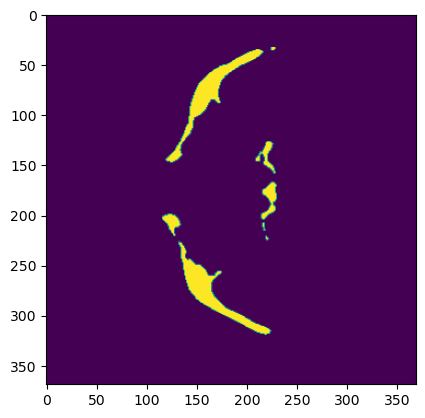

In [6]:
maxilla = cv2.imread(MAXILLA_FILE, cv2.IMREAD_GRAYSCALE)

plt.imshow(maxilla)

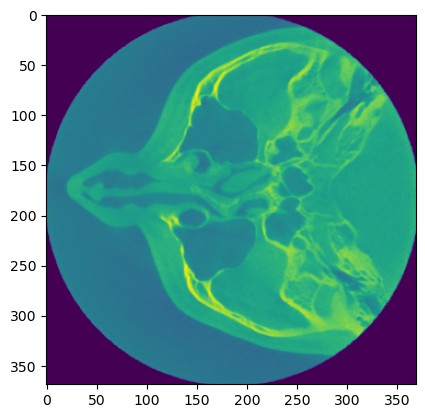

In [7]:
slice = cv2.imread(SLICE_FILE, cv2.IMREAD_GRAYSCALE)

plt.imshow(slice, )

In [8]:
print(slice.shape)

(369, 369)


In [9]:
white_pixels = []

for i in range(maxilla.shape[0]):
    for j in range(maxilla.shape[1]):
        if maxilla[i][j] > 0:
            white_pixels.append((i, j))


In [10]:
not_air = []
BLACK_BOUND = 130

for i in range(slice.shape[0]):
    for j in range(slice.shape[0]):
        if slice[i][j] > BLACK_BOUND:
            not_air.append((i, j))


In [11]:
start_point = min(white_pixels, key=lambda x: (abs(x[0] - 175), -x[1]))
left_corner = min(filter(lambda x: x[0] < 175, white_pixels), key=lambda x: x[1])
right_corner = min(filter(lambda x: x[0] > 175, white_pixels), key=lambda x: x[1])
finish_point = min(filter(lambda x: 100 <= x[0] <= 250, not_air), key=lambda x: x[1])

In [12]:
import queue

q = queue.PriorityQueue()

In [13]:
def cost(x0, y0, x1, y1):
    return 1 + 2 **(int(slice[x0][y0]) - int(slice[x1][y1]))


W = slice.shape[0]
H = slice.shape[1]
V = W * H
INF = 10 ** 9

dist = [[INF] * H for _ in range(W)]
prev = [[-1] * H for _ in range(W)]

dist[start_point[0]][start_point[1]] = 0

q.put((0, start_point[0], start_point[1]))

while q.qsize() > 0:
    d, x, y = q.get()
    if d != dist[x][y]:
        continue
    
    if x == finish_point[0] and y == finish_point[1]:
        break

    for dx in range(-1, 2):
        for dy in range(-1, 2):
            nx = dx + x
            ny = dy + y
            if 0 <= nx < W and 0 <= ny < H:
                if slice[nx][ny] > BLACK_BOUND:
                    if dist[nx][ny] > dist[x][y] + cost(x, y, nx, ny):
                        dist[nx][ny] = dist[x][y] + cost(x, y, nx, ny)
                        prev[nx][ny] = (x, y)
                        q.put((dist[nx][ny], nx, ny))
    

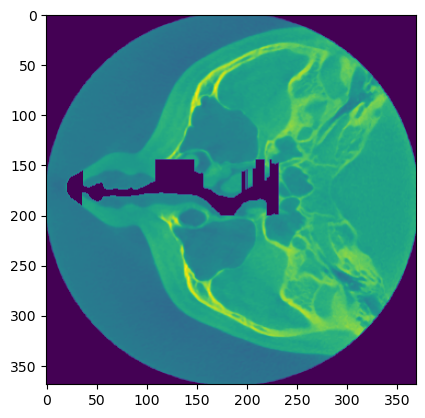

In [14]:
x, y = finish_point

while x != start_point[0] or y != start_point[1]:
    slice[x][y] = 0
    
    i = x - 1
    while slice[i][y] > BLACK_BOUND and i > left_corner[0]:
        slice[i][y] = 0
        i -= 1
    
    i = x + 1
    while slice[i][y] > BLACK_BOUND and i < right_corner[0]:
        slice[i][y] = 0
        i += 1

    x, y = prev[x][y]

plt.imshow(slice)

In [15]:
FROM = 154
TO = 175 # exclusive

array = np.zeros(shape=(W, H, TO - FROM))

for layer in range(FROM, TO):
    print(layer)
    maxilla_file =  os.path.join("output", "slices",  f"slice_{layer}_maxilla.png")
    maxilla = cv2.imread(maxilla_file, cv2.IMREAD_GRAYSCALE)
    slice_file = os.path.join("output", "slices", f"slice_{layer}.png")
    slice = cv2.imread(slice_file, cv2.IMREAD_GRAYSCALE)
    
    white_pixels = []

    for i in range(maxilla.shape[0]):
        for j in range(maxilla.shape[1]):
            if maxilla[i][j] > 0:
                white_pixels.append((i, j))

    
    not_air = []
    BLACK_BOUND = 130

    for i in range(slice.shape[0]):
        for j in range(slice.shape[0]):
            if slice[i][j] > BLACK_BOUND:
                not_air.append((i, j))

    
    start_point = min(white_pixels, key=lambda x: (abs(x[0] - 175), -x[1]))
    left_corner = min(filter(lambda x: x[0] < 175, white_pixels), key=lambda x: x[1])
    right_corner = min(filter(lambda x: x[0] > 175, white_pixels), key=lambda x: x[1])
    finish_point = min(filter(lambda x: 100 <= x[0] <= 250, not_air), key=lambda x: x[1])
    
    def cost(x0, y0, x1, y1):
        return 1 + 2 **(int(slice[x0][y0]) - int(slice[x1][y1]))

    dist = [[INF] * H for _ in range(W)]
    prev = [[-1] * H for _ in range(W)]

    dist[start_point[0]][start_point[1]] = 0

    q.put((0, start_point[0], start_point[1]))

    while q.qsize() > 0:
        d, x, y = q.get()
        if d != dist[x][y]:
            continue
        
        if x == finish_point[0] and y == finish_point[1]:
            break

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx = dx + x
                ny = dy + y
                if 0 <= nx < W and 0 <= ny < H:
                    if slice[nx][ny] > BLACK_BOUND:
                        if dist[nx][ny] > dist[x][y] + cost(x, y, nx, ny):
                            dist[nx][ny] = dist[x][y] + cost(x, y, nx, ny)
                            prev[nx][ny] = (x, y)
                            q.put((dist[nx][ny], nx, ny))
    x, y = finish_point

    while x != start_point[0] or y != start_point[1]:
        array[x][y][layer - FROM] = 1
        slice[x][y] = 0
        
        i = x - 1
        while slice[i][y] > BLACK_BOUND and i > left_corner[0]:
            array[i][y][layer - FROM] = 1
            slice[i][y] = 0
            i -= 1
        
        i = x + 1
        while slice[i][y] > BLACK_BOUND and i < right_corner[0]:
            array[i][y][layer - FROM] = 1
            slice[i][y] = 0
            i += 1

        x, y = prev[x][y]

154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


In [16]:
import vtk
import numpy as np

dims = array.shape
imageData = vtk.vtkImageData()
imageData.SetDimensions(dims[0], dims[1], dims[2])

scalars = vtk.vtkUnsignedCharArray()
scalars.SetNumberOfComponents(1)
scalars.SetName("scalars")
for k in range(dims[2]):
    for j in range(dims[1]):
        for i in range(dims[0]):
            value = array[i,j,k]
            scalars.InsertNextTuple1(value)
imageData.GetPointData().SetScalars(scalars)

mc = vtk.vtkMarchingCubes()
mc.SetInputData(imageData)
mc.ComputeNormalsOn()
mc.SetValue(0, 0.5)

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(mc.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

writer = vtk.vtkPolyDataWriter()
writer.SetFileName("output.vtk")
writer.SetInputConnection(mc.GetOutputPort())
writer.Write()

1